In [38]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [39]:
from mejiro.lenses import lens_util
detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

  0%|          | 0/166 [00:00<?, ?it/s]

100%|██████████| 166/166 [00:03<00:00, 53.81it/s]

Number of detectable lenses: 166


In [40]:
lens = np.random.choice(detectable_lenses)
print(f'Main halo mass: {np.log10(lens.main_halo_mass)}')

Main halo mass: 13.528389465580792


In [41]:
# TODO temporary fix
from astropy.cosmology import FlatLambdaCDM
lens.cosmo = FlatLambdaCDM(H0=67.66, Om0=0.30966, Ob0=0.04897)

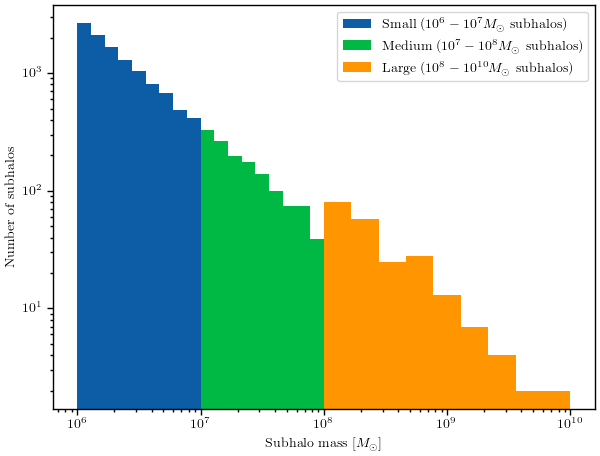

In [42]:
subhalo_cone = 5

small_subhalos = lens.generate_cdm_subhalos(log_mlow=6, log_mhigh=7, subhalo_cone=subhalo_cone)
medium_subhalos = lens.generate_cdm_subhalos(log_mlow=7, log_mhigh=8, subhalo_cone=subhalo_cone)
large_subhalos = lens.generate_cdm_subhalos(log_mlow=8, log_mhigh=10, subhalo_cone=subhalo_cone)

# f, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.hist([h.mass for h in small_subhalos.halos], label='Small ($10^6-10^7 M_\odot$ subhalos)', bins=np.logspace(6, 7, 10))
plt.hist([h.mass for h in medium_subhalos.halos], label='Medium ($10^7-10^8 M_\odot$ subhalos)', bins=np.logspace(7, 8, 10))
plt.hist([h.mass for h in large_subhalos.halos], label='Large ($10^8-10^{10} M_\odot$ subhalos)', bins=np.logspace(8, 10, 10))
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Subhalo mass [$M_\odot$]')
plt.ylabel('Number of subhalos')
plt.show()

In [43]:
lens_with_small_subhalos = deepcopy(lens)
lens_with_medium_subhalos = deepcopy(lens)
lens_with_large_subhalos = deepcopy(lens)

lens_with_small_subhalos.add_subhalos(small_subhalos)
lens_with_medium_subhalos.add_subhalos(medium_subhalos)
lens_with_large_subhalos.add_subhalos(large_subhalos)

oversample = 3
num_pix = 45
side = 4.95
small_total_kappa = lens_with_small_subhalos.get_total_kappa(num_pix=num_pix * oversample, side=side)
small_subhalo_kappa = lens_with_small_subhalos.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
medium_total_kappa = lens_with_medium_subhalos.get_total_kappa(num_pix=num_pix * oversample, side=side)
medium_subhalo_kappa = lens_with_medium_subhalos.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
large_total_kappa = lens_with_large_subhalos.get_total_kappa(num_pix=num_pix * oversample, side=side)
large_subhalo_kappa = lens_with_large_subhalos.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)

In [44]:
einstein_radius = lens.get_einstein_radius()
print(f'Einstein radius: {einstein_radius:.2f} arcsec or about {einstein_radius / 0.11 * oversample:.0f} pixels')

Einstein radius: 0.31 arcsec or about 9 pixels


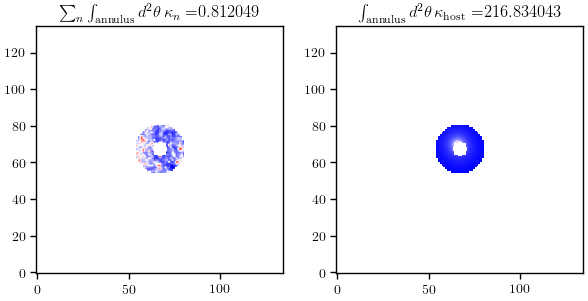

In [45]:
small_f_sub, ax_small = lens_with_small_subhalos.get_f_sub(num_pix=num_pix * oversample, side=side, plot=True)

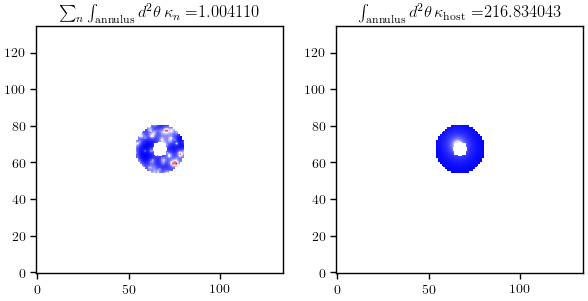

In [46]:
medium_f_sub, ax_medium = lens_with_medium_subhalos.get_f_sub(num_pix=num_pix * oversample, side=side, plot=True)

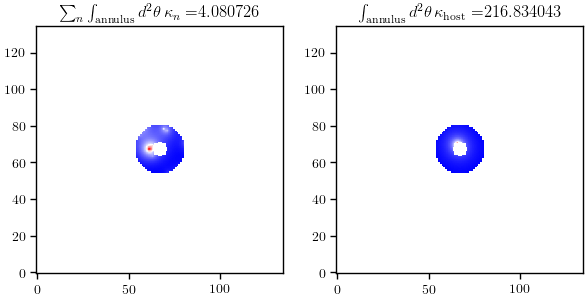

In [47]:
large_f_sub, ax_large = lens_with_large_subhalos.get_f_sub(num_pix=num_pix * oversample, side=side, plot=True)

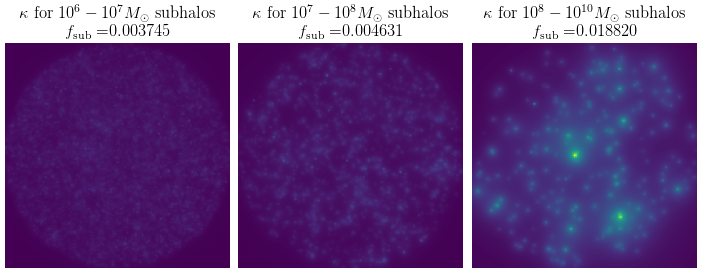

In [48]:
vmax = np.max(large_subhalo_kappa)

_, ax = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
ax[0].imshow(small_subhalo_kappa, vmin=0, vmax=vmax)
ax[1].imshow(medium_subhalo_kappa, vmin=0, vmax=vmax)
ax[2].imshow(large_subhalo_kappa, vmin=0, vmax=vmax)
for a in ax: a.axis('off')
ax[0].set_title(r'$\kappa$' + ' for $10^6-10^7 M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{small_f_sub:.6f}')
ax[1].set_title(r'$\kappa$' + ' for $10^7-10^8 M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{medium_f_sub:.6f}')
ax[2].set_title(r'$\kappa$' + ' for $10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{large_f_sub:.6f}')
plt.show()

Now, combine these subhalo populations so we have three populations with different lower-end mass cutoffs:
1. $10^6-10^{10} M_\odot$, like CDM
2. $10^7-10^{10} M_\odot$, like WDM with less dramatic lower-end mass cutoff
3. $10^8-10^{10} M_\odot$, like WDM with more dramatic lower-end mass cutoff

In [49]:
lens_1 = deepcopy(lens)
lens_2 = deepcopy(lens)
lens_3 = deepcopy(lens)

lens_1_subhalos = deepcopy(large_subhalos).join(deepcopy(medium_subhalos)).join(deepcopy(small_subhalos))
lens_2_subhalos = deepcopy(large_subhalos).join(deepcopy(medium_subhalos))
lens_3_subhalos = deepcopy(large_subhalos)

lens_1.add_subhalos(lens_1_subhalos)
lens_2.add_subhalos(lens_2_subhalos)
lens_3.add_subhalos(lens_3_subhalos)

lens_1_total_kappa = lens_1.get_total_kappa(num_pix=num_pix * oversample, side=side)
lens_1_subhalo_kappa = lens_1.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
lens_2_total_kappa = lens_2.get_total_kappa(num_pix=num_pix * oversample, side=side)
lens_2_subhalo_kappa = lens_2.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)
lens_3_total_kappa = lens_3.get_total_kappa(num_pix=num_pix * oversample, side=side)
lens_3_subhalo_kappa = lens_3.get_subhalo_kappa(num_pix=num_pix * oversample, side=side)

lens_1_f_sub, _ = lens_1.get_f_sub(num_pix=num_pix * oversample, side=side, plot=False)
lens_2_f_sub, _ = lens_2.get_f_sub(num_pix=num_pix * oversample, side=side, plot=False)
lens_3_f_sub, _ = lens_3.get_f_sub(num_pix=num_pix * oversample, side=side, plot=False)

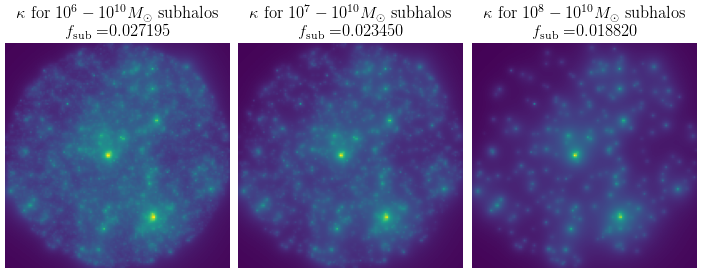

In [50]:
vmax = np.max(lens_3_subhalo_kappa)

_, ax = plt.subplots(1, 3, figsize=(7, 3), constrained_layout=True)
ax[0].imshow(lens_1_subhalo_kappa, vmin=0, vmax=vmax)
ax[1].imshow(lens_2_subhalo_kappa, vmin=0, vmax=vmax)
ax[2].imshow(lens_3_subhalo_kappa, vmin=0, vmax=vmax)
for a in ax: a.axis('off')
ax[0].set_title(r'$\kappa$' + ' for $10^6-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_1_f_sub:.6f}')
ax[1].set_title(r'$\kappa$' + ' for $10^7-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_2_f_sub:.6f}')
ax[2].set_title(r'$\kappa$' + ' for $10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_3_f_sub:.6f}')
plt.show()

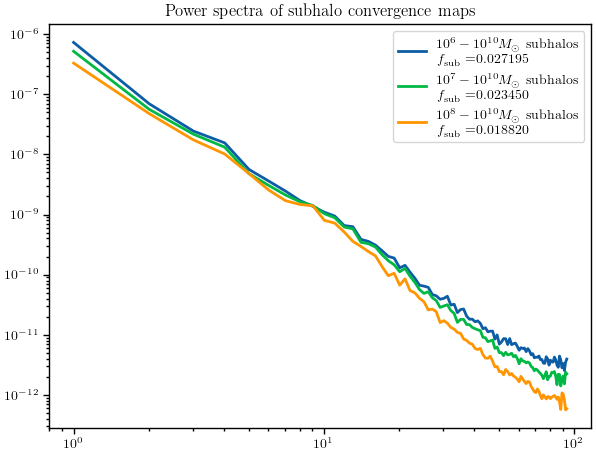

In [51]:
from lenstronomy.Util.correlation import power_spectrum_1d

lens_1_kappa_power_spectrum, k1 = power_spectrum_1d(lens_1_subhalo_kappa)
lens_2_kappa_power_spectrum, k2 = power_spectrum_1d(lens_2_subhalo_kappa)
lens_3_kappa_power_spectrum, k3 = power_spectrum_1d(lens_3_subhalo_kappa)

plt.loglog(k1, lens_1_kappa_power_spectrum, label=r'$10^6-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_1_f_sub:.6f}')
plt.loglog(k2, lens_2_kappa_power_spectrum, label=r'$10^7-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_2_f_sub:.6f}')
plt.loglog(k3, lens_3_kappa_power_spectrum, label=r'$10^8-10^{10} M_\odot$ subhalos ' + '\n$f_{\mathrm{sub}} = $' + f'{lens_3_f_sub:.6f}')
plt.legend()
plt.title('Power spectra of subhalo convergence maps')
plt.show()

In [52]:
lens_1_model = lens_1.get_array(num_pix=num_pix * oversample, side=side, band='F129')
lens_2_model = lens_2.get_array(num_pix=num_pix * oversample, side=side, band='F129')
lens_3_model = lens_3.get_array(num_pix=num_pix * oversample, side=side, band='F129')
lens_model = lens.get_array(num_pix=num_pix * oversample, side=side, band='F129')

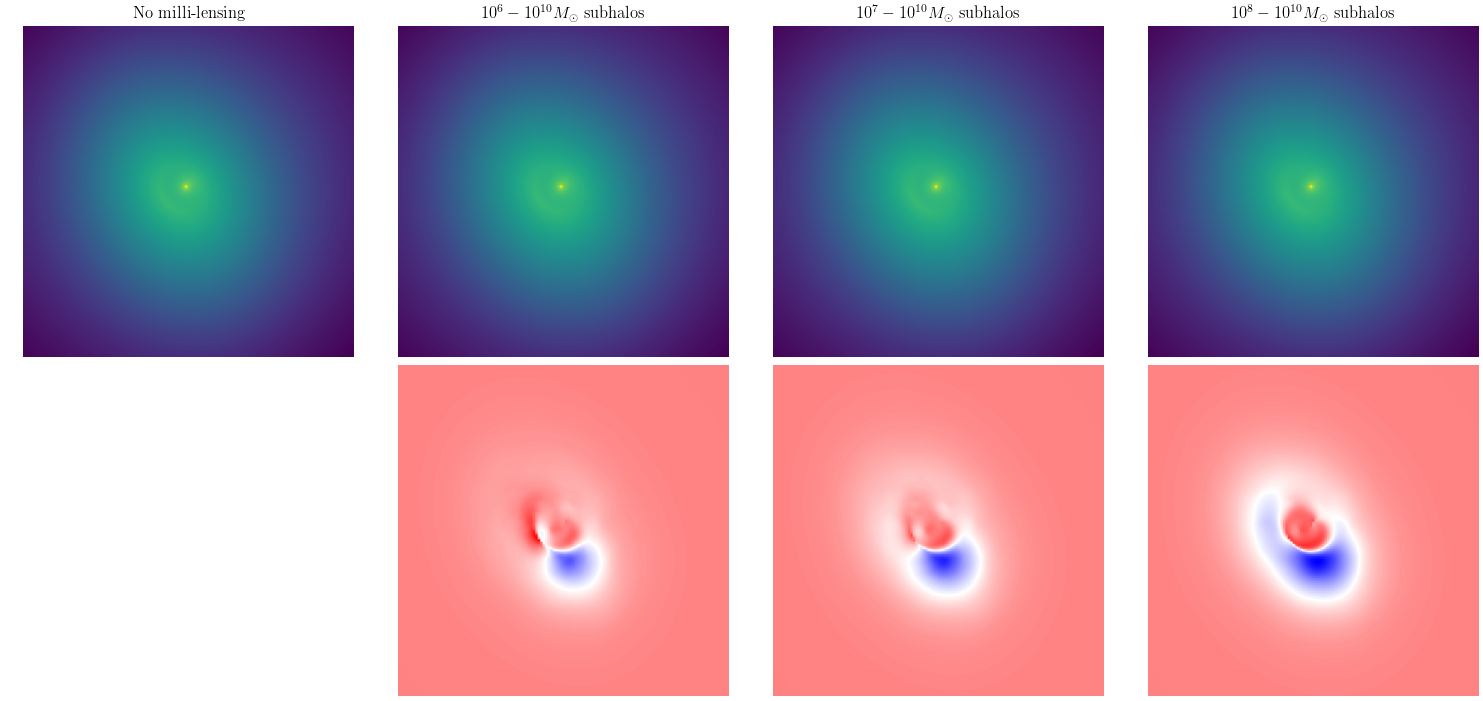

In [60]:
vmax = np.max([lens_1_model - lens_model, lens_2_model - lens_model, lens_3_model - lens_model])
vmin= np.min([lens_1_model - lens_model, lens_2_model - lens_model, lens_3_model - lens_model])

f, ax = plt.subplots(2, 4, figsize=(15, 7), constrained_layout=True)
ax[0][0].imshow(np.log10(lens_model))
ax[0][1].imshow(np.log10(lens_1_model))
ax[0][2].imshow(np.log10(lens_2_model))
ax[0][3].imshow(np.log10(lens_3_model))
ax[1][1].imshow(lens_1_model - lens_model, cmap='bwr', vmin=vmin, vmax=vmax)
ax[1][2].imshow(lens_2_model - lens_model, cmap='bwr', vmin=vmin, vmax=vmax)
ax[1][3].imshow(lens_3_model - lens_model, cmap='bwr', vmin=vmin, vmax=vmax)
for a in ax: 
    for b in a: b.axis('off')
ax[0][0].set_title('No milli-lensing')
ax[0][1].set_title(r'$10^6-10^{10} M_\odot$ subhalos')
ax[0][2].set_title(r'$10^7-10^{10} M_\odot$ subhalos')
ax[0][3].set_title(r'$10^8-10^{10} M_\odot$ subhalos')
plt.show()

In [54]:
# overplot massive subhalo positions?